In [1]:
import cv2
import glob
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from pprint import pprint
import albumentations as A
import torch.optim as optim
from torch.nn import BCELoss
from torch.optim import Adam
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.transforms as tt
from segmentation.models import all_models
from mpl_toolkits.axes_grid1 import ImageGrid
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

plt.style.use("dark_background")

c:\Users\Aditya Bapat\Desktop\project\brain-tumor-segmentation-project\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importing Dataset

In [2]:
# Path to all data
DATA_PATH = "./dataset/kaggle_3m/"

# img size
IMG_SIZE = 512

In [3]:
# Raw data
import os
import glob
data_map = []
for sub_dir_path in glob.glob(DATA_PATH+"*"):
    if os.path.isdir(sub_dir_path):
        dirname = sub_dir_path.split("/")[-1]
        for filename in os.listdir(sub_dir_path):
            image_path = sub_dir_path + "/" + filename
            data_map.extend([dirname, image_path])
    else:
        print("This is not a dir:", sub_dir_path)
        
        
df = pd.DataFrame({"dirname" : data_map[::2],
                  "path" : data_map[1::2]})
df.head()

This is not a dir: ./dataset/kaggle_3m\data.csv
This is not a dir: ./dataset/kaggle_3m\README.md


,dirname,path
0,kaggle_3m\TCGA_CS_4941_19960909,./dataset/kaggle_3m\TCGA_CS_4941_19960909/TCGA...
1,kaggle_3m\TCGA_CS_4941_19960909,./dataset/kaggle_3m\TCGA_CS_4941_19960909/TCGA...
2,kaggle_3m\TCGA_CS_4941_19960909,./dataset/kaggle_3m\TCGA_CS_4941_19960909/TCGA...
3,kaggle_3m\TCGA_CS_4941_19960909,./dataset/kaggle_3m\TCGA_CS_4941_19960909/TCGA...
4,kaggle_3m\TCGA_CS_4941_19960909,./dataset/kaggle_3m\TCGA_CS_4941_19960909/TCGA...


Exploratory Data Analysis

In [4]:
# Masks/Not masks
df_imgs = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]

print(df_imgs["path"].values[0][50: -4])
print(df_masks["path"].values[0][50:-9])

# Data sorting
imgs = sorted(df_imgs["path"].values, key=lambda x : int(x[slice(55, -9)]))
masks = sorted(df_masks["path"].values, key=lambda x : int(x[slice(55, -9)]))

# Sorting check
idx = random.randint(0, len(imgs)-1)
print("Path to the Image:", imgs[idx], "\nPath to the Mask:", masks[idx])

4941_19960909_1
4941_19960909_10
Path to the Image: ./dataset/kaggle_3m\TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_17.tif 
Path to the Mask: ./dataset/kaggle_3m\TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_17_mask.tif


In [5]:
# Final dataframe
df = pd.DataFrame({"patient": df_imgs.dirname.values,
                       "image_path": imgs,
                   "mask_path": masks})


# Adding A/B column for diagnosis
def positiv_negativ_diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    if value > 0 : return 1
    else: return 0

df["diagnosis"] = df["mask_path"].apply(lambda m: positiv_negativ_diagnosis(m))
df

,patient,image_path,mask_path,diagnosis
0,kaggle_3m\TCGA_CS_4941_19960909,./dataset/kaggle_3m\TCGA_DU_6399_19830416/TCGA...,./dataset/kaggle_3m\TCGA_DU_6399_19830416/TCGA...,0
1,kaggle_3m\TCGA_CS_4941_19960909,./dataset/kaggle_3m\TCGA_DU_6399_19830416/TCGA...,./dataset/kaggle_3m\TCGA_DU_6399_19830416/TCGA...,0
2,kaggle_3m\TCGA_CS_4941_19960909,./dataset/kaggle_3m\TCGA_DU_6399_19830416/TCGA...,./dataset/kaggle_3m\TCGA_DU_6399_19830416/TCGA...,0
3,kaggle_3m\TCGA_CS_4941_19960909,./dataset/kaggle_3m\TCGA_DU_6399_19830416/TCGA...,./dataset/kaggle_3m\TCGA_DU_6399_19830416/TCGA...,0
4,kaggle_3m\TCGA_CS_4941_19960909,./dataset/kaggle_3m\TCGA_DU_6399_19830416/TCGA...,./dataset/kaggle_3m\TCGA_DU_6399_19830416/TCGA...,0
...,...,...,...,...
3924,kaggle_3m\TCGA_HT_A61B_19991127,./dataset/kaggle_3m\TCGA_FG_A60K_20040224/TCGA...,./dataset/kaggle_3m\TCGA_FG_A60K_20040224/TCGA...,0
3925,kaggle_3m\TCGA_HT_A61B_19991127,./dataset/kaggle_3m\TCGA_FG_A60K_20040224/TCGA...,./dataset/kaggle_3m\TCGA_FG_A60K_20040224/TCGA...,0
3926,kaggle_3m\TCGA_HT_A61B_19991127,./dataset/kaggle_3m\TCGA_FG_A60K_20040224/TCGA...,./dataset/kaggle_3m\TCGA_FG_A60K_20040224/TCGA...,0
3927,kaggle_3m\TCGA_HT_A61B_19991127,./dataset/kaggle_3m\TCGA_FG_A60K_20040224/TCGA...,./dataset/kaggle_3m\TCGA_FG_A60K_20040224/TCGA...,0


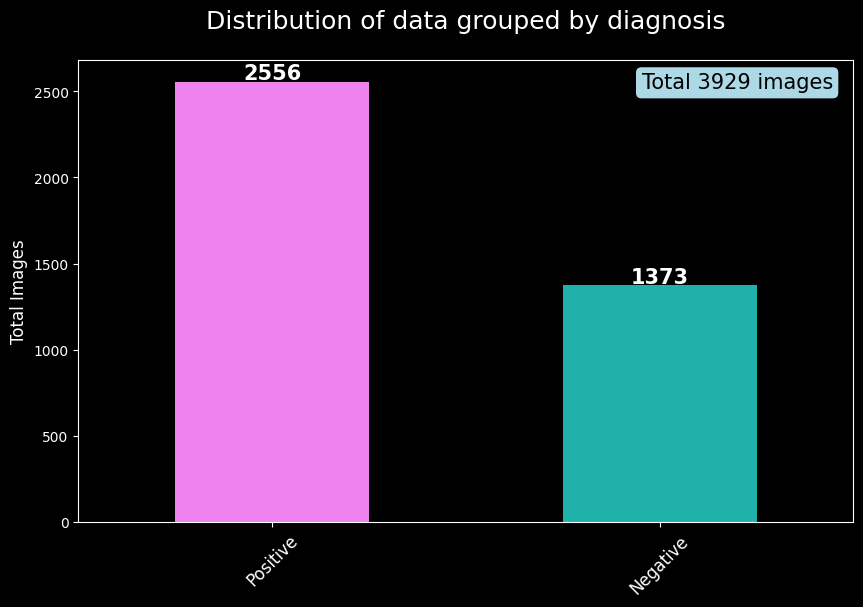

In [6]:
# Plot
ax = df.diagnosis.value_counts().plot(kind='bar',
                                      stacked=True,
                                      figsize=(10, 6),
                                     color=["violet", "lightseagreen"])


ax.set_xticklabels(["Positive", "Negative"], rotation=45, fontsize=12);
ax.set_ylabel('Total Images', fontsize = 12)
ax.set_title("Distribution of data grouped by diagnosis",fontsize = 18, y=1.05)

# Annotate
for i, rows in enumerate(df.diagnosis.value_counts().values):
    ax.annotate(int(rows), xy=(i, rows-12), 
                rotation=0, color="white", 
                ha="center", verticalalignment='bottom', 
                fontsize=15, fontweight="bold")
    
ax.text(1.2, 2550, f"Total {len(df)} images", size=15,
        color="black",
         ha="center", va="center",
         bbox=dict(boxstyle="round",
                   fc=("lightblue"),
                   ec=("black"),
                   )
         );

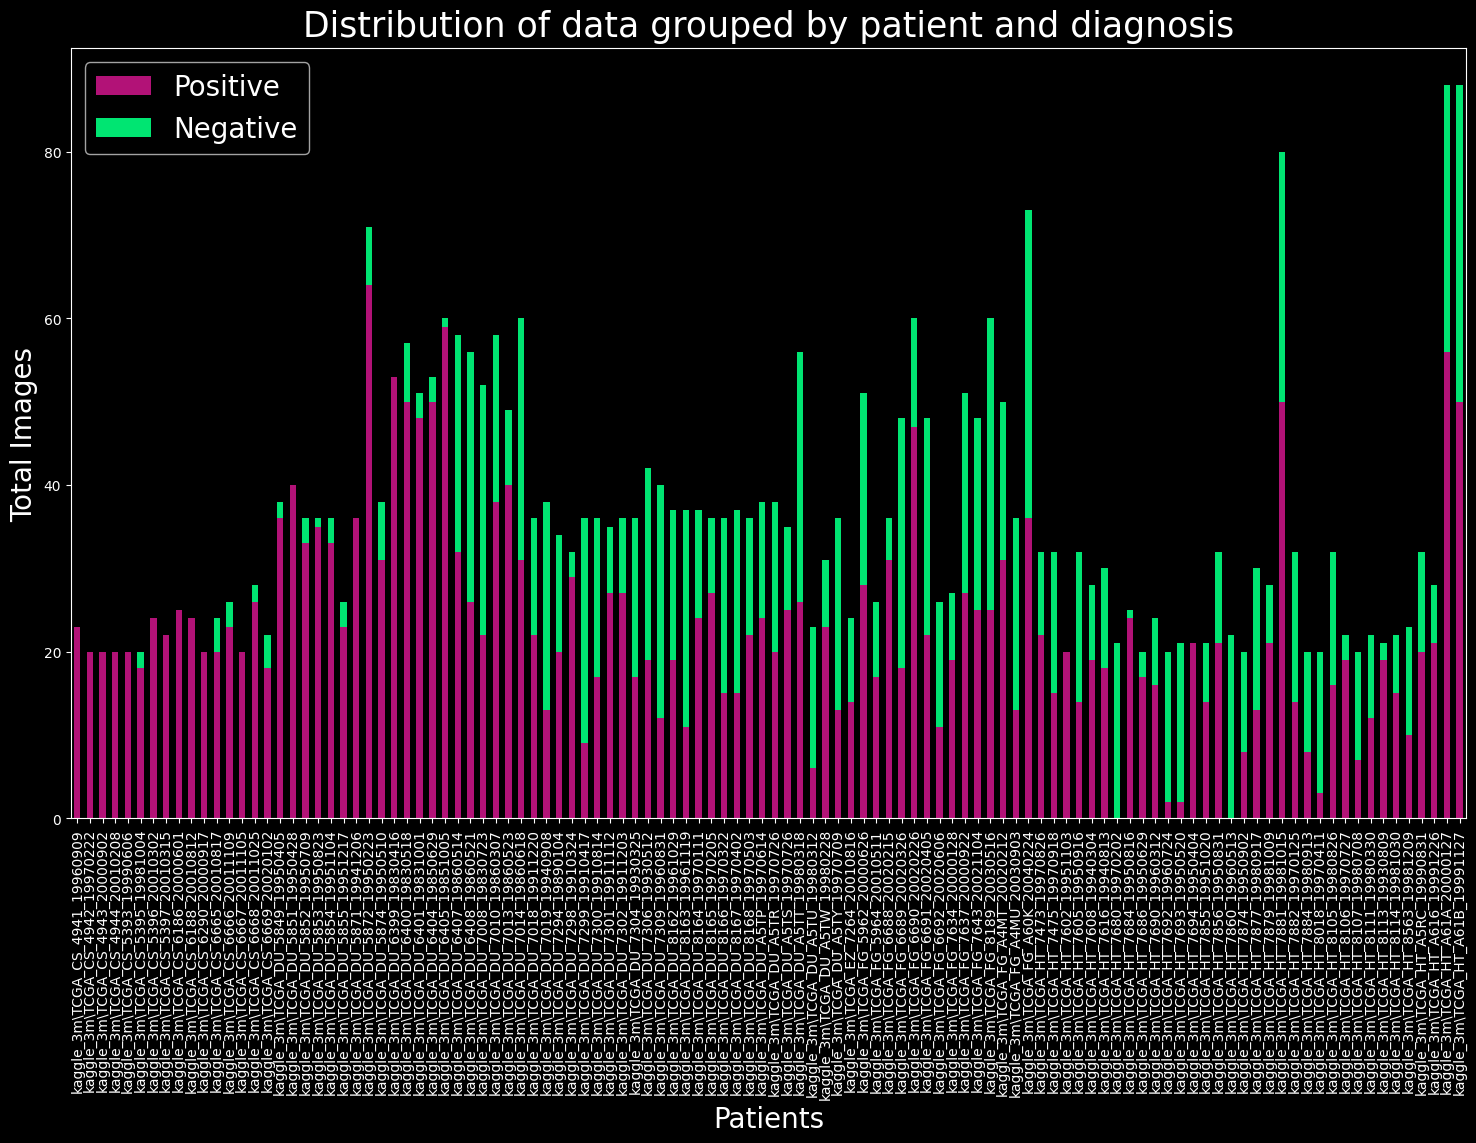

In [7]:
# Data
patients_by_diagnosis = df.groupby(['patient', 'diagnosis'])['diagnosis'].size().unstack().fillna(0)
patients_by_diagnosis.columns = ["Positive", "Negative"]

# Plot
ax = patients_by_diagnosis.plot(kind='bar',stacked=True,
                                figsize=(18, 10),
                                color=["mediumvioletred", "springgreen"], 
                                alpha=0.9)
ax.legend(fontsize=20);
ax.set_xlabel('Patients',fontsize = 20)
ax.set_ylabel('Total Images', fontsize = 20)
ax.set_title("Distribution of data grouped by patient and diagnosis",fontsize = 25, y=1.005)

# Annotations
"""for i, rows in enumerate(patients_by_diagnosis.values):
    plt.annotate(int(rows[0]), xy=(i, rows[0]+1), rotation=90, color="white")
    plt.annotate(int(rows[1]), xy=(i, rows[1]+1), rotation=90, color="aqua")""";

Data Visualization

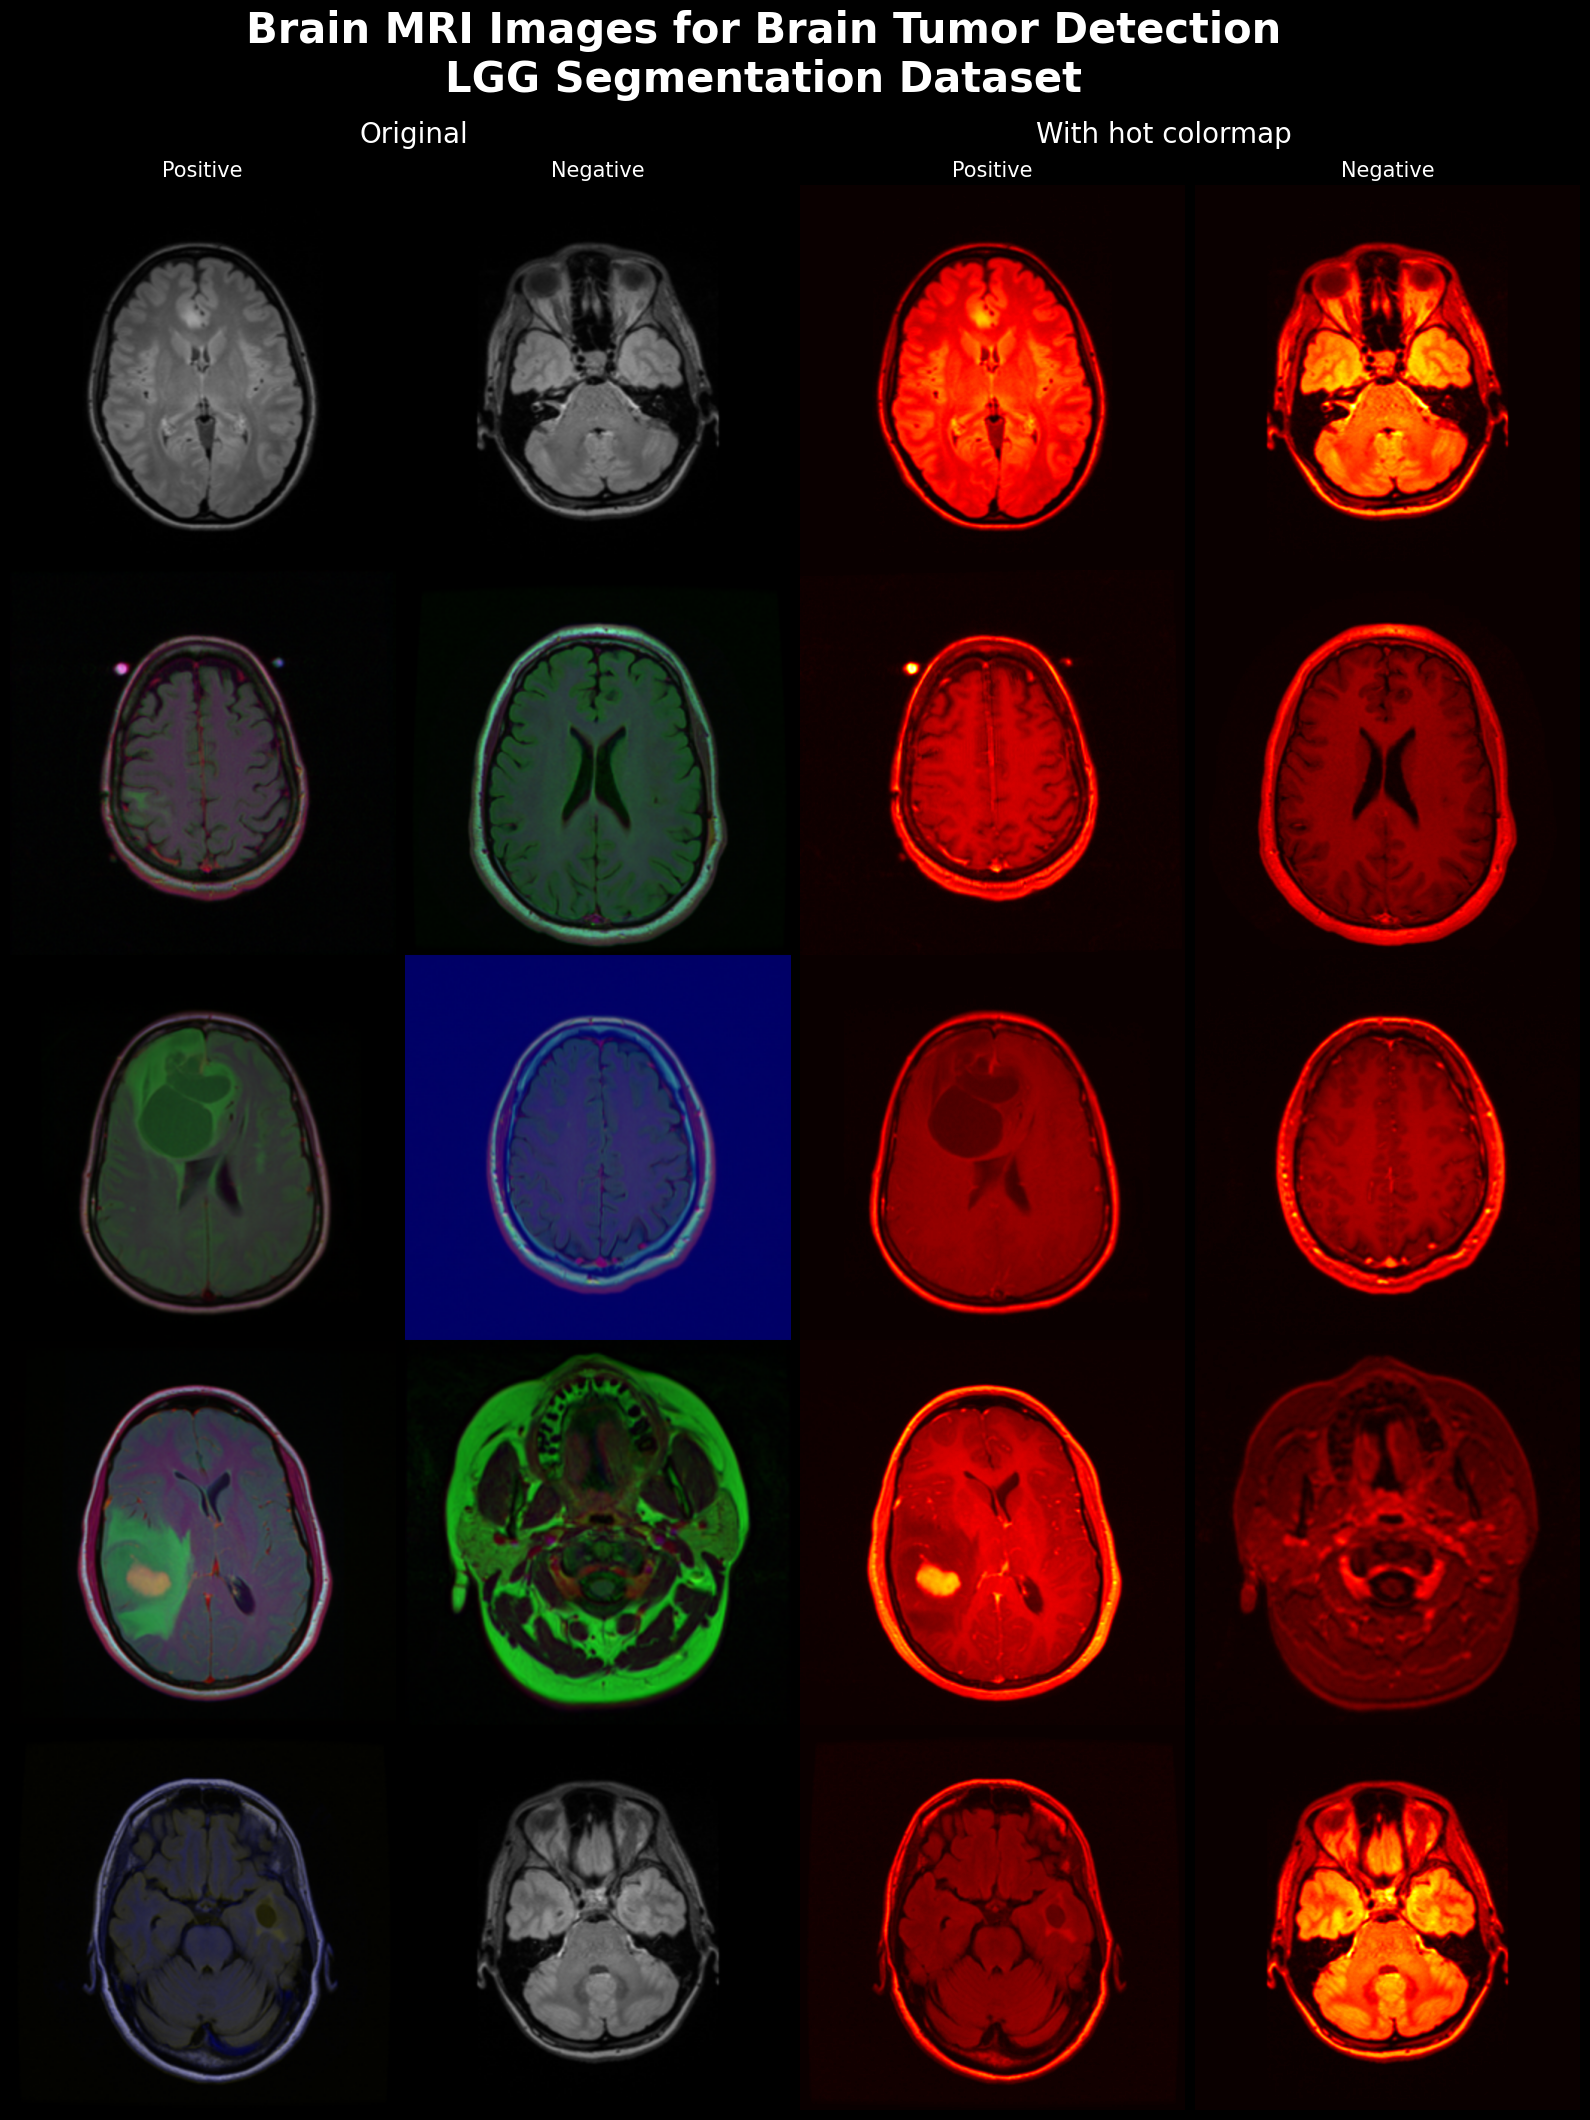

In [8]:
# Data
sample_yes_df = df[df["diagnosis"] == 1].sample(5).image_path.values
sample_no_df = df[df["diagnosis"] == 0].sample(5).image_path.values

sample_imgs = []
for i, (yes, no) in enumerate(zip(sample_yes_df, sample_no_df)):
    yes = cv2.resize(cv2.imread(yes), (IMG_SIZE, IMG_SIZE))
    no = cv2.resize(cv2.imread(no), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([yes, no])


sample_yes_arr = np.vstack(np.array(sample_imgs[::2]))
sample_no_arr = np.vstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(1, 4),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_yes_arr)
grid[0].set_title("Positive", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_no_arr)
grid[1].set_title("Negative", fontsize=15)
grid[1].axis("off")

grid[2].imshow(sample_yes_arr[:,:,0], cmap="hot")
grid[2].set_title("Positive", fontsize=15)
grid[2].axis("off")
grid[3].imshow(sample_no_arr[:,:,0], cmap="hot")
grid[3].set_title("Negative", fontsize=15)
grid[3].axis("off")#set_title("No", fontsize=15)

# annotations
plt.figtext(0.36,0.90,"Original", va="center", ha="center", size=20)
plt.figtext(0.66,0.90,"With hot colormap", va="center", ha="center", size=20)
plt.suptitle("Brain MRI Images for Brain Tumor Detection\nLGG Segmentation Dataset", y=.95, fontsize=30, weight="bold")

# save and show
plt.savefig("dataset_image.png", bbox_inches='tight', pad_inches=0.2, transparent=True)
plt.show()

Samples of images and masks with a positive diagnosis

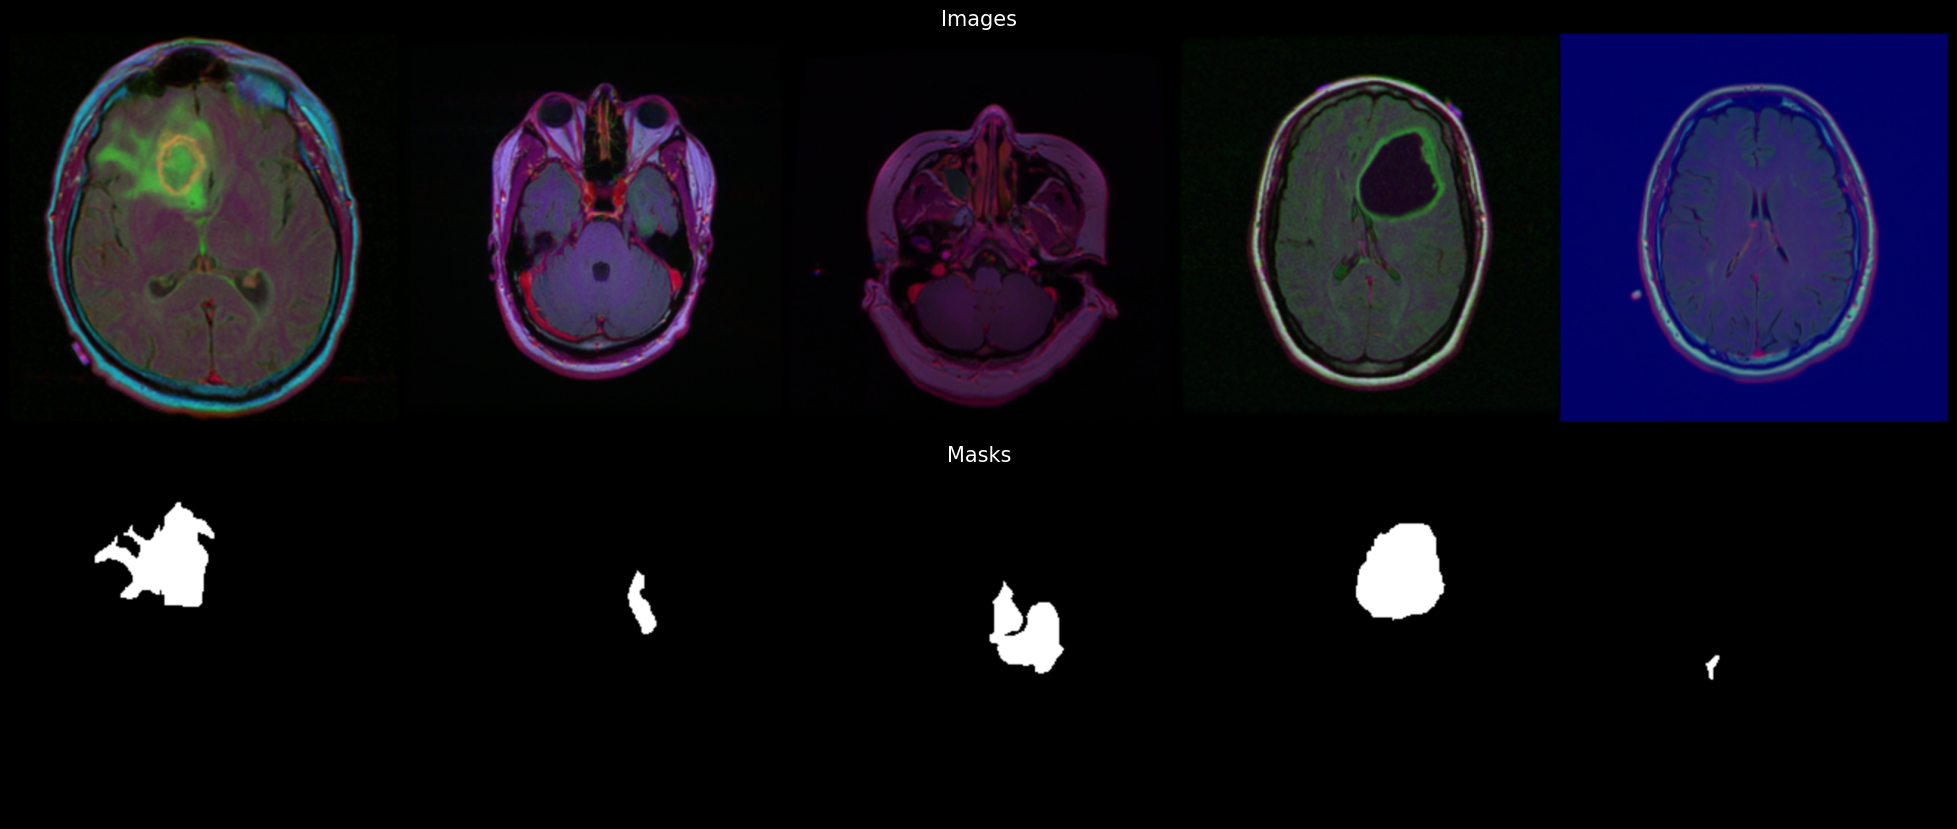

In [9]:
# Data
sample_df = df[df["diagnosis"] == 1].sample(5).values
sample_imgs = []
for i, data in enumerate(sample_df):
    #print(data)
    img = cv2.resize(cv2.imread(data[1]), (IMG_SIZE, IMG_SIZE))
    mask = cv2.resize(cv2.imread(data[2]), (IMG_SIZE, IMG_SIZE))
    sample_imgs.extend([img, mask])


sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")
plt.show()